In [1]:
import numpy as np
import xarray as xr
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from osgeo import gdal, ogr, gdal_array
import dask
import datacube 
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.utils import geometry
import os
#import custom functions
import sys
sys.path.append('src')
import DEAPlotting, SpatialTools, BandIndices, DEADataHandling
from load_data import load_data
from transform_tuple import transform_tuple
from query_from_shp import query_from_shp
from rsgislib.segmentation import segutils
from rasterstats import zonal_stats
from imageSeg import imageSeg
import fiona
import rasterio.features

import warnings
warnings.filterwarnings('ignore')

In [2]:
# where is your data and results folder?
results = "results/"
data = 'data/'

sensors = ['ls5', 'ls7','ls8']

#are we using a polygon to mask the AOI?
shp_fpath = 'data/spatial/murrumbidgee_boundingbox.shp'

#Input your area of interest's name, coords, and 
#the year you're interested in?
AOI = 'Murrum_randomForest'
year = 'Winter2016'

time_period = ('2016-04-01', '2016-09-30')

#What thresholds should I use?
threshold = 0.8
wofs_theshold = 0.15
#-----------------------------------------

In [3]:
#Creating a folder to keep things neat
directory = results + AOI + "_" + year
if not os.path.exists(directory):
    os.mkdir(directory)

results = results + AOI + "_" + year + "/"

In [4]:
#set up query
query = query_from_shp(shp_fpath, time_period[0], time_period[1], dask_chunks = 500)
#landsat
# dc = datacube.Datacube(app='dc_name')
# landsat = DEADataHandling.load_clearlandsat(dc,query=query, sensors=sensors, product='nbart',
#                        masked_prop=0.75)

landsat = load_data(dc_name = 'irrigated_areas', sensors=sensors, export_name = 'fh',query=query)
#wofs
# dc = datacube.Datacube(app='wofs')
# del query['time'] 
# wofs_alltime = dc.load(product = 'wofs_summary', **query)

#masking the returned array to the polygon area
with fiona.open(shp_fpath) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

mask = rasterio.features.geometry_mask([geom.to_crs(landsat.geobox.crs) for geoms in [geom]],
                                           out_shape=landsat.geobox.shape,
                                           transform=landsat.geobox.affine,
                                           all_touched=False,
                                           invert=True)
# Mask the xarrays
landsat = landsat.where(mask)
#wofs_alltime = wofs_alltime.where(mask)
#datacube.storage.storage.write_dataset_to_netcdf(landsat, results + AOI "_" + year + '.nc')

ls5_loading...
ls5_loaded
ls7_loading...
ls7_loaded
ls8_loading...
ls8_loaded


In [8]:
#band indices calculation
# def ndvi_ufunc(ds):
#     def ndvi_func(nir, red):
#         return ((nir - red)/(nir + red))
    
#     return xr.apply_ufunc(
#         ndvi_func, ds.nir, ds.red,
#         dask='parallelized',
#         output_dtypes=[float])

def brightness_ufunc(ds):
    def brightness_func(g,r,nir,swir):
        return (g**2 + r**2 + nir**2 + swir**2)**(1/2.0)
    
    return xr.apply_ufunc(
        brightness_func, ds.green,ds.red, ds.nir, ds.swir1,
        dask='parallelized',
        output_dtypes=[float])

def greenness_ufunc(ds):
    def greenness_func(nir,g):
        return nir/g
    
    return xr.apply_ufunc(
        greenness_func, ds.nir,ds.green,
        dask='parallelized',
        output_dtypes=[float])

# ds.nir - ds.swir1)/(ds.nir + ds.swir1

# NDVI_landsat = ndvi_ufunc(landsat)
NDMI_landsat = BandIndices.calculate_indices(landsat, index='NDMI-nir')
brightness_landsat = brightness_ufunc(landsat)
greenness_landsat = greenness_ufunc(landsat)

#calculate NDVI & NDMI stats

print('calculating NDVI & NDMI stats')
# NDVI_max = NDVI_landsat.max('time').rename('NDVI_max')
# NDVI_mean = NDVI_landsat.mean('time').rename('NDVI_mean')
# NDVI_std = NDVI_landsat.std('time').rename('NDVI_std')
# NDVI_min = NDVI_landsat.min('time').rename('NDVI_min')
# NDVI_range = NDVI_max - NDVI_min
# NDVI_range = NDVI_range.rename('NDVI_range')

green_max = greenness_landsat.max('time').rename('NDVI_max')
green_mean = greenness_landsat.mean('time').rename('NDVI_mean')
green_std = greenness_landsat.std('time').rename('NDVI_std')
green_min = greenness_landsat.min('time').rename('NDVI_min')
green_range = green_max - green_min
green_range = green_range.rename('NDVI_range')

NDMI_max = NDMI_landsat.max('time').rename('NDMI_max')
NDMI_mean = NDMI_landsat.mean('time').rename('NDMI_mean')
NDMI_std = NDMI_landsat.std('time').rename('NDMI_std')
NDMI_min = NDMI_landsat.min('time').rename('NDMI_min')

#brightness stats
brightness_max = brightness_landsat.max('time').rename('brightness_max')
brightness_mean = brightness_landsat.mean('time').rename('brightness_mean')
brightness_std = brightness_landsat.std('time').rename('brightness_std')
brightness_min = brightness_landsat.min('time').rename('brightness_min')

greenness_landsat_resample = greenness_landsat.resample(time='M').mean('time')

def nanarg(xarr, dim, stat):
    """
    Deals with all-NaN slices by first identifying the offending cells
    to create a mask, then filling NaNs with an integer to calculate
    nanargmax(min), then masking out all-NaN cells using the mask.
    The fill number is set such that it will never be returned as the min
    or max of the argmax(min).
    """
    mask = xarr.min(dim=dim, skipna=True).isnull()
    if stat=='max':
        fill = np.nanmin(xarr.values) -1
        y = xarr.fillna(fill)
        y = y.argmax(dim=dim, skipna=True).astype(float)
        y = y.where(~mask)
        return y
    if stat == 'min':
        fill = np.nanmax(xarr.values) + 1
        y = xarr.fillna(fill)
        y = y.argmin(dim=dim, skipna=True).astype(float)
        y = y.where(~mask)
        return y
print("calculating rate etc")
timeofmax = nanarg(greenness_landsat_resample,dim ='time', stat='max')
timeofmin = nanarg(greenness_landsat_resample,dim ='time', stat='min')

rate = (green_max-green_min)/(timeofmax - timeofmin)
rate = rate.where(~np.isinf(rate), other=3) #remove unreasonable values #remove unreasonable values



The formula we are using is (nir - swir1)/(nir + swir1)
calculating NDVI & NDMI stats
calculating rate etc


In [9]:
# NDVI_max, NDVI_mean, NDVI_std, NDVI_min, NDVI_range,
xray_list = [green_max, green_mean, green_std, green_min, green_range,
             NDMI_max, NDMI_mean, NDMI_std, NDMI_min,timeofmax, timeofmin, rate,
             brightness_max, brightness_mean, brightness_std, brightness_std]
names = ['green_max', 'green_mean', 'green_std', 'green_min', 'green_range',
         'NDMI_max', 'NDMI_mean', 'NDMI_std', 'NDMI_min','timeofmax', 'timeofmin','rate',
            'brightness_max', 'brightness_mean', 'brightness_std', 'brightness_std']

### Image segmentation for use in masking AFTER the RF classifier

In [10]:
#export Gtiff for use in Image segmentation
transform, projection = transform_tuple(green_max, (green_max.x, green_max.y), epsg=3577)
SpatialTools.array_to_geotiff(results + AOI + "_" + year + "_green_max.tif",
              green_max.values, geo_transform = transform, 
              projection = projection, nodata_val=np.nan)

# #export all GTiffs for catchment so I don't have to keep loading them.
# for l, n in zip(xray_list, names):
#     SpatialTools.array_to_geotiff(results + AOI + "_" + year + "_" + n + ".tif",
#               l.values, geo_transform = transform, 
#               projection = projection, nodata_val=np.nan)

In [11]:
InputNDVIStats = results + AOI + "_" + year + "_green_max.tif"
KEAFile = results + AOI + '_' + year + '.kea'
SegmentedKEAFile = results + AOI + '_' + year + '_sheperdSEG.kea'
SegmentedTiffFile = results + AOI + '_' + year + '_sheperdSEG.tif'
SegmentedPolygons = results + AOI + '_' + year + '_SEGpolygons.shp'
imageSeg(InputNDVIStats, KEAFile, SegmentedKEAFile, SegmentedTiffFile, SegmentedPolygons, minPxls = 100)

Stretch Input Image
Add 1 to stretched file to ensure there are no all zeros (i.e., no data) regions created.
Create Input Image Mask.
Mask stretched Image.
Deleting file: ./Murrum_randomForest_Winter2016_stchdonly.kea
Deleting file: ./Murrum_randomForest_Winter2016_stchdonlyOff.kea
Deleting file: ./Murrum_randomForest_Winter2016_stchdmaskonly.kea
Performing KMeans.
Apply KMeans to image.
Eliminate Single Pixels.
Perform clump.
Eliminate small pixels.
Relabel clumps.
Calculate image statistics and build pyramids.
Deleting file: ./Murrum_randomForest_Winter2016_kmeansclusters.gmtxt
Deleting file: ./Murrum_randomForest_Winter2016_kmeans.kea
Deleting file: ./Murrum_randomForest_Winter2016_kmeans.kea.aux.xml
Deleting file: ./Murrum_randomForest_Winter2016_kmeans_nosgl.kea
Deleting file: ./Murrum_randomForest_Winter2016_kmeans_nosglTMP.kea
Deleting file: ./Murrum_randomForest_Winter2016_clumps.kea
Deleting file: ./Murrum_randomForest_Winter2016_clumps_elim.kea
Deleting file: ./Murrum_random

### Generate a training dataset

I was generating the training dataset in the code below that is now commented out,

have since moved to generating a random dataset using R.  10,000 points extracted

per class across from the OEH landuse layer. Rasterizing this file directly. UPDATE: The training dataset

is now being hand drawn using sentinel imagery because the OEH landuse later isn't fit-for-purpose


In [ ]:
# #rasterize the training dataset
# NDVI_max = xr.open_rasterio(results + AOI + "_" + year + "_NDVI_max.tif")
# NDVI_max = NDVI_max.squeeze()
# #get the transform and projection of our gtiff
# transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
# #find the width and height of the xarray dataset we want to mask
# width,height = NDVI_max.shape
# # rasterize vector
# training_set = SpatialTools.rasterize_vector(results + "murrumbidgee_training_samples.shp",
#                height, width, transform, projection, field='id',raster_path= results + AOI + "_" + year +'training_raster.tif')
# #xr.DataArray(training_set, coords = [NDVI_max.y, NDVI_max.x], dims = ['y', 'x'], name='training areas').plot(figsize=(10,10))

Exporting raster to results/Murrum_randomForest_Winter2016/Murrum_randomForest_Winter2016training_raster.tif


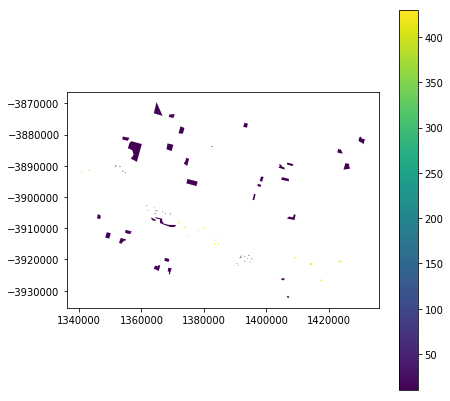

In [49]:
peel_landuse = gpd.read_file('results/Murrum_randomForest_Winter2013/hand_trainingSet.shp')
peel_landuse = peel_landuse.to_crs(epsg=3577)

peel_trainset = peel_landuse[(peel_landuse.Id == 430)| # irrigated cropping
                        (peel_landuse.Id == 330) |      #cropping
                        (peel_landuse.Id == 133) |      #native cover (bushland)
                        (peel_landuse.Id == 541)]       #urban

peel_trainset = peel_trainset[['Id', 'geometry']]

# peel_trainset = peel_trainset.replace([330,133,541], 10) #testing just two classes

peel_trainset.to_file(results + "waggaHAND_trainset.shp")
peel_trainset.plot(column = 'Id', legend=True, figsize=(7,7))

# #rasterize the training dataset
NDVI_max = xr.open_rasterio(results + AOI + "_" + year + "_green_max.tif")
NDVI_max = NDVI_max.squeeze()
#get the transform and projection of our gtiff
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = NDVI_max.shape
# rasterize vector
training_set = SpatialTools.rasterize_vector(results + "waggaHAND_trainset.shp",
               height, width, transform, projection, field='Id',raster_path= results + AOI + "_" + year +'training_raster.tif')
# xr.DataArray(training_set, coords = [NDVI_max.y, NDVI_max.x], dims = ['y', 'x'], name='training areas').plot(figsize=(10,10))

In [54]:
k = xr.open_rasterio(results + AOI + "_" + year +'training_raster.tif')
k = k.squeeze()
classes = np.unique(k)
for c in classes:
    print('Class {c} contains {n} pixels'.format(c=c,n=(training_set == c).sum()))

Class 0 contains 3519415 pixels
Class 10 contains 28819 pixels
Class 430 contains 3613 pixels


### Create a Random Forest Model

In [55]:
# Read in our training data
roi_ds = gdal.Open(results + AOI + "_" + year +'training_raster.tif', gdal.GA_ReadOnly)
roi = roi_ds.GetRasterBand(1).ReadAsArray().astype(np.uint16)

convert to numpy arrays (SLOW BECAUSE DASK ARRAYS ARE COMPUTED)
x,y = NDVI_max.shape
z = len(xray_list)
img = np.zeros((x,y,z))
count=0
for b,c in zip(xray_list, range(img.shape[2])):
    count += 1
    progress = round((count/z) * 100, 3)
    print("\r", "adding slice: " + str(count) + ", " + str(progress) + "%" + " complete. ", end = '')
    img[:, :, c] = b.values 
    
img_noNaNs = np.nan_to_num(img) #remove nans as they f/w classifier
np.save(results + 'img_noNaNs.npy', img_noNaNs) #save it as binary

In [ ]:
# use this cell if importing .npy file
# img_noNaNs = np.load(results + 'img_noNaNs.npy')

Text(0.5, 1.0, 'AOI Training Data')

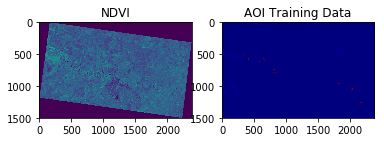

In [57]:
# # Display them
plt.subplot(121)
plt.imshow(img_noNaNs[:, :, 1])
plt.title('NDVI')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.jet)
plt.title('AOI Training Data')

In [58]:
# Find how many non-zero entries we have -- i.e. how many training data samples?
n_samples = (roi > 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(roi[roi > 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
x = img_noNaNs[roi > 0,:]
y = roi[roi > 0]

print('Our x matrix is sized: {sz}'.format(sz=x.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 32432 samples
The training data include 2 classes: [ 10 430]
Our x matrix is sized: (32432, 16)
Our y array is sized: (32432,)


In [59]:
from sklearn.ensemble import RandomForestClassifier
# Initialize our model with 300 trees, and use 4 cpus
rf = RandomForestClassifier(n_estimators=300, oob_score=True, verbose=True,
                            n_jobs=4, max_features="auto") #auto = sqrt(n_features)

# Fit our model to training data
rf = rf.fit(x, y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    4.9s finished


In [60]:
#save the model
from joblib import dump, load
dump(rf, results + 'murrumbidgee_rfModel.joblib')

['results/Murrum_randomForest_Winter2016/murrumbidgee_rfModel.joblib']

In [61]:
print('Our OOB prediction of accuracy is: {oob}%'.format(oob=rf.oob_score_ * 100))

Our OOB prediction of accuracy is: 99.80883078441046%


In [62]:
#display the importance of the individual bands
for b, imp in zip(names, rf.feature_importances_):
    print('Band {b} importance: {imp}'.format(b=b, imp=imp))

Band green_max importance: 0.09265494305825324
Band green_mean importance: 0.07328849997698941
Band green_std importance: 0.02975254313237425
Band green_min importance: 0.05843982675030611
Band green_range importance: 0.0626173664100342
Band NDMI_max importance: 0.07388039527173088
Band NDMI_mean importance: 0.10580706953428579
Band NDMI_std importance: 0.023694781247985366
Band NDMI_min importance: 0.12896246958917998
Band timeofmax importance: 0.02490816487994173
Band timeofmin importance: 0.04462910279654718
Band rate importance: 0.058900245227432854
Band brightness_max importance: 0.07206679840846235
Band brightness_mean importance: 0.11035924027697616
Band brightness_std importance: 0.020991623783345695
Band brightness_std importance: 0.019046929656154964


In [63]:
# Create a cross-tabulation dataframe to check out how each class performs
df = pd.DataFrame()
df['truth'] = y
df['predict'] = rf.predict(x)

# Cross-tabulate predictions
print(pd.crosstab(df['truth'], df['predict'], margins=True))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:    0.3s finished


predict     10   430    All
truth                      
10       28819     0  28819
430          0  3613   3613
All      28819  3613  32432


### Classify our image

In [64]:
# If we need to load back in the trained RF model:
# rf = load(results + 'murrumbidgee_rfModel.joblib')

# Take our full image, and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img_noNaNs.shape[0] * img_noNaNs.shape[1], img_noNaNs.shape[2])

img_as_array = img_noNaNs[:, :, :z].reshape(new_shape)
print('Reshaped from {o} to {n}'.format(o=img_noNaNs.shape,
                                        n=img_as_array.shape))

# Now predict for each pixel
print('generating prediction')
class_prediction = rf.predict(img_as_array)

# Reshape our classification map
class_prediction = class_prediction.reshape(img_noNaNs[:, :, 0].shape)

Reshaped from (1493, 2379, 16) to (3551847, 16)
generating prediction


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    8.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   31.4s
[Parallel(n_jobs=4)]: Done 300 out of 300 | elapsed:   47.4s finished


Text(0.5, 1.0, 'Irrigation Pixels Only')

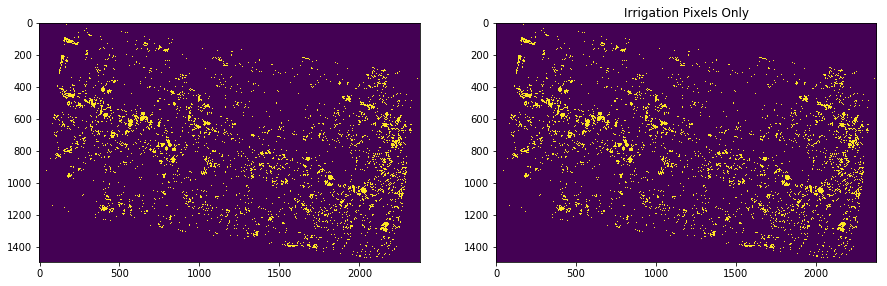

In [65]:
#generate a plot of the predictions
import matplotlib.patches as mpatches
values = np.unique(class_prediction.ravel())

plt.figure(figsize=(15,15))
plt.subplot(121)
im = plt.imshow(class_prediction, interpolation='none')
# colors = [im.cmap(im.norm(value)) for value in values]
# patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.subplot(122)
irr = np.where(class_prediction==430, 1, 0)
plt.imshow(irr)
plt.title('Irrigation Pixels Only')

In [69]:
#export out the results
transform, projection = transform_tuple(NDVI_max, (NDVI_max.x, NDVI_max.y), epsg=3577)
SpatialTools.array_to_geotiff(results + AOI + "_" + year + "classpredict_handtrain.tif",
              class_prediction, geo_transform = transform, 
              projection = projection, nodata_val=0)

### use image segmentation polygons to filter results of RF

In [ ]:
class_predict = xr.open_rasterio(results + AOI + "_" + year + "classpredict_handtrain.tif")
class_predict = class_predict.squeeze()

gdf = gpd.read_file(results + AOI + '_' + year + '_SEGpolygons.shp')
#calculate majority values inside segments
gdf['majority'] = pd.DataFrame(zonal_stats(vectors=gdf['geometry'], raster=results + AOI + "_" + year + "classpredict_handtrain.tif", stats='majority'))['majority']
#calculate area of polygons
gdf['area'] = gdf['geometry'].area
#filter by area and majority values
smallArea = gdf['area'] <= 5500000
irrigated = gdf['majority'] == 430.0 #filtering for irrigated areas only
gdf = gdf[smallArea&irrigated]
#export shapefile
gdf.to_file(results + AOI + "_" + year + "_Irrigated.shp")

#get the transform and projection of our gtiff
transform, projection = transform_tuple(class_predict, (class_predict.x, class_predict.y), epsg=3577)
#find the width and height of the xarray dataset we want to mask
width,height = class_predict.shape
# rasterize vector
gdf_raster = SpatialTools.rasterize_vector(results + AOI + "_" + year + "_Irrigated.shp",
                                           height, width, transform, projection, raster_path=results + AOI + "_" + year + "_Irrigated.tif")

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(gdf_raster, interpolation='none')